In [12]:
import tensorflow as tf                                                                                                                          
from energyflow.archs import PFN                                                                                                                 
from training_functions import *                                                                                                                 
from sklearn.preprocessing import StandardScaler                                                                                                 
import h5py as h5                                                                                                                                
import matplotlib.pyplot as plt                                                                                                       
import numpy as np                                                                                                                               
import os                                                                                                                                        
import shutil

from matplotlib import style
#style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')
colors = ['#348ABD','#C70039','#FF5733','#FFC300','#65E88F','#40E0D0']

## GPU Set up

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)                                          

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Reading the train split and test data from hdf5 file

In [14]:
particle="pi+"
rate=5e-3
batch_size = 1_000 

## CHANGE "NEW_DIR" ACCORDINGLY

if particle=='e-':
    h5_filename = '/media/miguel/Elements/Data_hcali/Data1/e-_623k_standalone_0_80GeV_train_split.hdf5'
    new_dir=f"standalone_model_623k_{particle}_1k_{rate}"
elif particle=='pi+':
    h5_filename = '/media/miguel/Elements/Data_hcali/Data1/pi+_495k_0_100GeV_train_split.hdf5'
    new_dir=f"aaastandalone_model_495k_{particle}_1k_{rate}" ## the the directory name where you want your output file
else:
    print('WHAT IS PARTICLE')
    
    
h5_file = h5.File(h5_filename,'r')
working_dir=os.getcwd()
#new_dir=f"standalone_model_80k_pi+_1k_{rate}"
try:
    os.makedirs(f"{working_dir}/{new_dir}",exist_ok=True)
except OSError:
    print("Directory creation Error "%new_dir)
else:
    print("Directory %s is created"%new_dir)
label = new_dir  #Replace with your own variation!      
path = "./"+label
print(path)       

###  Make TRUE directory if there is not any to store mean and std
shutil.rmtree('True', ignore_errors=True)                                                                       
os.makedirs('True') 

Directory aaastandalone_model_495k_pi+_1k_0.005 is created
./aaastandalone_model_495k_pi+_1k_0.005


## Define the generators: Treating our samples as an infinite stream of data, reading one chunk at a time

In [15]:
recalc_scalar = True
N_Scalar_Batches = 10
do_norm = True #False for Debugging ONLY
train_generator = tf.data.Dataset.from_generator(
    training_generator(h5_filename,'train_hcali','train_mc',batch_size,do_norm,path,recalc_scalar),
    output_shapes=(tf.TensorShape([None,None,None]),[None]),
    output_types=(tf.float64, tf.float64))
 
val_generator = tf.data.Dataset.from_generator(
    training_generator(h5_filename,'val_hcali','val_mc',batch_size,do_norm,path,recalc_scalar),
    output_shapes=(tf.TensorShape([None,None,None]),[None]),
    output_types=(tf.float64, tf.float64))

test_generator = tf.data.Dataset.from_generator(                                                                                              
    test_generator(h5_filename,'test_hcali','test_mc',batch_size,do_norm,path,recalc_scalar),                                                                                
    output_shapes=(tf.TensorShape([None,None,None])),                                                                                            
    output_types=(tf.float64))

__________ ./aaastandalone_model_495k_pi+_1k_0.005/train_hcali_means.npy
Calculating Mean and Stdev using 100 batches for train_hcali
I am here hehheheheh ./aaastandalone_model_495k_pi+_1k_0.005
Calculating Mean and Stdev using 100 batches for train_mc
__________ ./aaastandalone_model_495k_pi+_1k_0.005/val_hcali_means.npy
Calculating Mean and Stdev using 100 batches for val_hcali
I am here hehheheheh ./aaastandalone_model_495k_pi+_1k_0.005
Calculating Mean and Stdev using 100 batches for val_mc
__________ ./aaastandalone_model_495k_pi+_1k_0.005/test_hcali_means.npy
Calculating Mean and Stdev using 100 batches for test_hcali
I am here hehheheheh ./aaastandalone_model_495k_pi+_1k_0.005
Calculating Mean and Stdev using 100 batches for test_mc


get_np_from_gen(h5_filename,n_batches,batch_size=1000,do_norm=True):## QA Immediatley Before Training: 
Plot the Cell Data for Training, Validation, and Test Datasets

In [16]:
input_array,target_array,val_input_data,val_target_data,test_array = \
get_np_from_gen(h5_filename,10,batch_size=1000,do_norm=True)

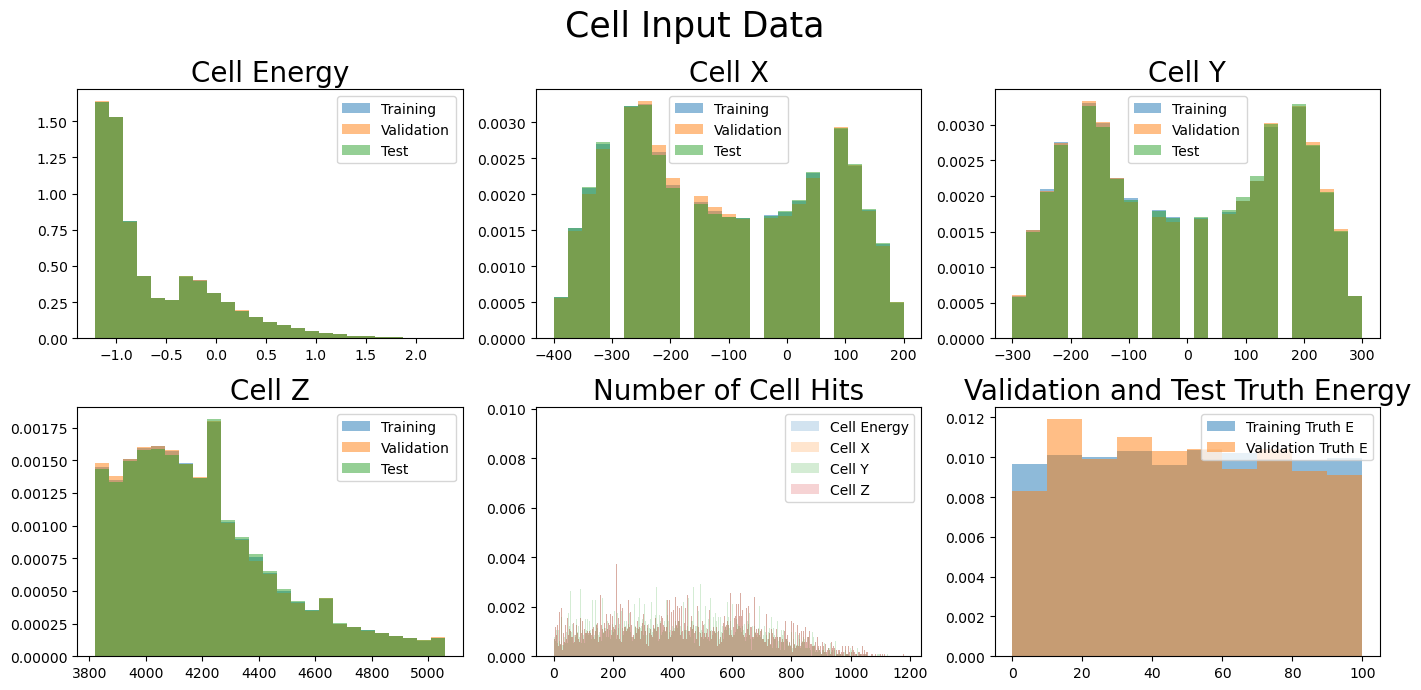

In [5]:
cell_vars = ["Cell Energy","Cell X","Cell Y","Cell Z"]

fig,axes=plt.subplots(2,3,figsize=(14,7))
axes = axes.ravel()
density = True
for i in range(input_array.shape[-1]):
    axes[i].hist(np.ravel(input_array[:,:,i][input_array[:,:,i]!=0]),alpha=0.5,label="Training",bins=25,density=density)
    axes[i].hist(np.ravel(val_input_data[:,:,i][val_input_data[:,:,i]!=0]),alpha=0.5,label="Validation",bins=25,density=density)
    axes[i].hist(np.ravel(test_array[:,:,i][test_array[:,:,i]!=0]),alpha=0.5,label="Test",bins=25,density=density)
    axes[i].legend(fontsize=10)
    axes[i].set_title("%s"%(cell_vars[i]),fontsize=20)

    #N Cell Hits
    axes[4].hist(np.ravel(np.count_nonzero(input_array[:,:,i],axis=-1)),
             bins=1000,alpha=0.2,
             density=True, label=cell_vars[i])
    
axes[4].legend(fontsize=10)
axes[4].set_title("Number of Cell Hits",fontsize=20)
    
axes[5].hist(target_array,alpha=0.5,label="Training Truth E",density=True)
axes[5].hist(val_target_data,alpha=0.5,label="Validation Truth E",density=True)
axes[5].legend(fontsize=10)
axes[5].set_title("Validation and Test Truth Energy",fontsize=20)
        
plt.suptitle("Cell Input Data",fontsize=25)
plt.tight_layout()
    
#plt.savefig("%s/Normalized_Cell_Data.pdf"%(path))

## Hyper Parameters

In [21]:
h5_file = h5.File(h5_filename,'r')
do_normalization = True                                                                                       
input_dim = h5_file['train_hcali'].shape[-2] #should be 4: Cell E,X,Y,Z, the number of features per particle   
learning_rate = rate                                                                                        
dropout_rate = 0.05                                                                                           
batch_size = 1_000                                                                                            
#N_Epochs = 50                                                                                                
N_Epochs = 1                                                                                                
patience = 10                                                                                                 
N_Latent = 128                                                                                                
shuffle_split = True #Turn FALSE for images!                                                                  
train_shuffle = True #Turn TRUE for images!                                                                   
Y_scalar = True                                                                                               
loss = 'mse' #'mae' ' mse'#'swish'                                                                                  

## Define Model + CallBacks

In [22]:
Phi_sizes, F_sizes = (100, 100, N_Latent), (100, 100, 100)
output_act, output_dim = 'linear', 1 #Train to predict error

pfn = PFN(input_dim=input_dim,                                                                                
          Phi_sizes=Phi_sizes,                                                                                
          F_sizes=F_sizes,                                                                                    
          output_act=output_act,                                                                              
          output_dim=output_dim,                                                                              
          loss=loss,                                                                                          
          latent_dropout=dropout_rate,                                                                        
          F_dropouts=dropout_rate,                                                                            
          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

### CallBacks

In [23]:
# Tensorflow CallBacks                                                                                        
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay,verbose=0)                                   
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)                                          
history_logger=tf.keras.callbacks.CSVLogger(path+"/log.csv", separator=",", append=True)                      
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path, save_best_only=True)                     
callbacks=[lr_scheduler, early_stopping,history_logger,batch_history(),model_checkpoint] 

# FIT

In [25]:

history = pfn.fit(                                                                                            
    train_generator,                                                                                          
    epochs=N_Epochs,                                                                                          
    batch_size=batch_size,                                                                                    
    callbacks=callbacks,                                                                                      
    validation_data=val_generator,                                                                            
    verbose=1                                                                                                 
)


'\nhistory = pfn.fit(                                                                                            \n    train_generator,                                                                                          \n    epochs=N_Epochs,                                                                                          \n    batch_size=batch_size,                                                                                    \n    callbacks=callbacks,                                                                                      \n    validation_data=val_generator,                                                                            \n    verbose=1                                                                                                 \n)\n'

In [ ]:
#save batch loss                                                                                              
np.save("%s/batch_loss.npy"%(path),batch_history.batch_loss)                                                  
                                                                                                              
#save epoch loss                                                                                              
with open(path+'/history_file', 'wb') as hist_file:                                                           
    pickle.dump(history.history, hist_file)                                                                   
                                                                                                              
pfn.layers                                                                                                    
pfn.save("%s/energy_regression.h5"%(path))                                                                    
mypreds = pfn.predict(test_generator, batch_size=1000)                                                        
np.save("%s/predictions.npy"%(path),mypreds)                                                                  
#FIXME: un-norm the predictions 